In [ ]:
!pip install numpy opencv-python albumentations matplotlib tqdm

# Data Augmentation

허깅페이스에서 데이터셋 로드 중...
데이터셋 로드 완료!

데이터셋 구조:
DatasetDict({
    train: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 1502
    })
    test: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 215
    })
    valid: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 429
    })
})

훈련 데이터셋 크기: 1502 이미지

데이터셋 특성:
{'file_name': Value(dtype='string', id=None), 'image': Image(mode=None, decode=True, id=None), 'id': Value(dtype='int64', id=None), 'category_id': ClassLabel(names=['Tumor', '0', '1'], id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'segmentation': Sequence(f

데이터 준비 중: 100%|██████████| 1502/1502 [00:06<00:00, 220.66it/s]



데이터 증강 시작: 1502 이미지에 각 3개 증강 적용


이미지 증강 중:   0%|          | 0/1502 [00:00<?, ?it/s]

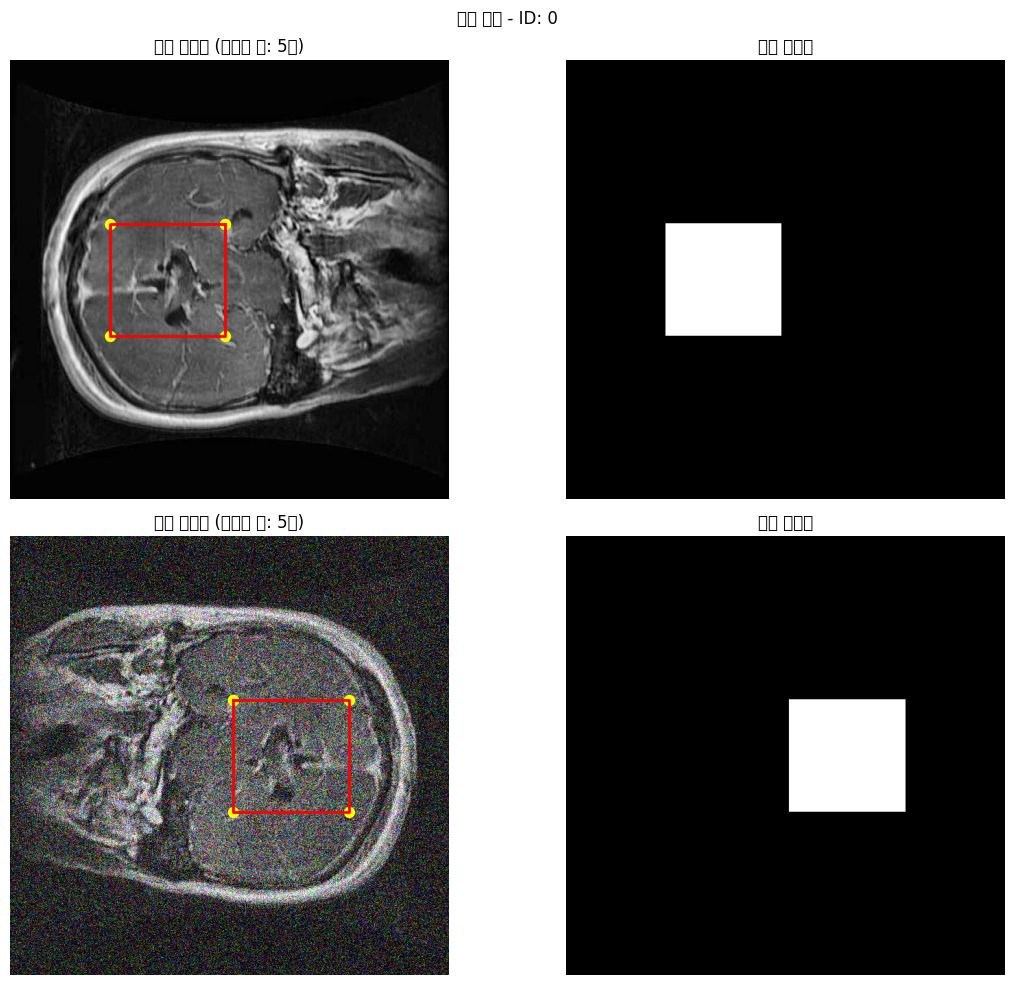

이미지 증강 중:   0%|          | 1/1502 [00:00<11:22,  2.20it/s]

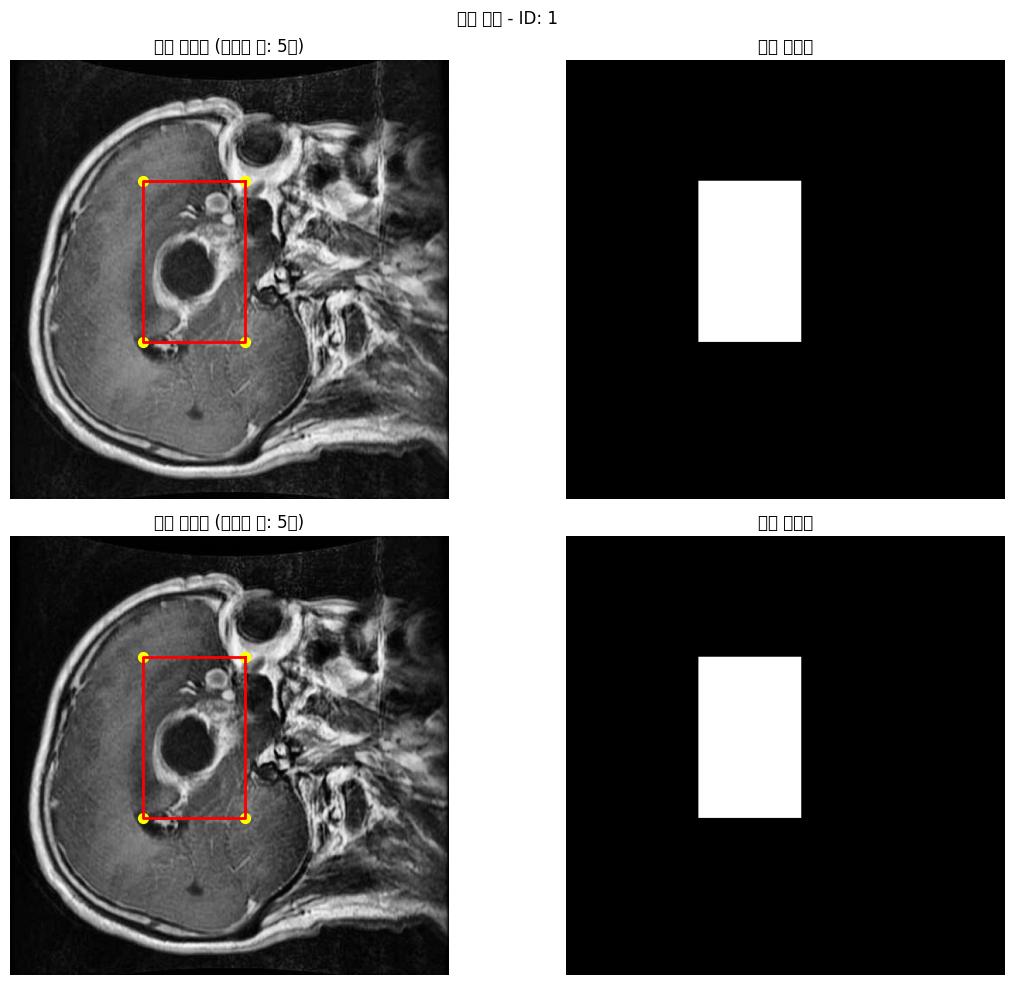

이미지 증강 중:   0%|          | 2/1502 [00:00<10:18,  2.42it/s]

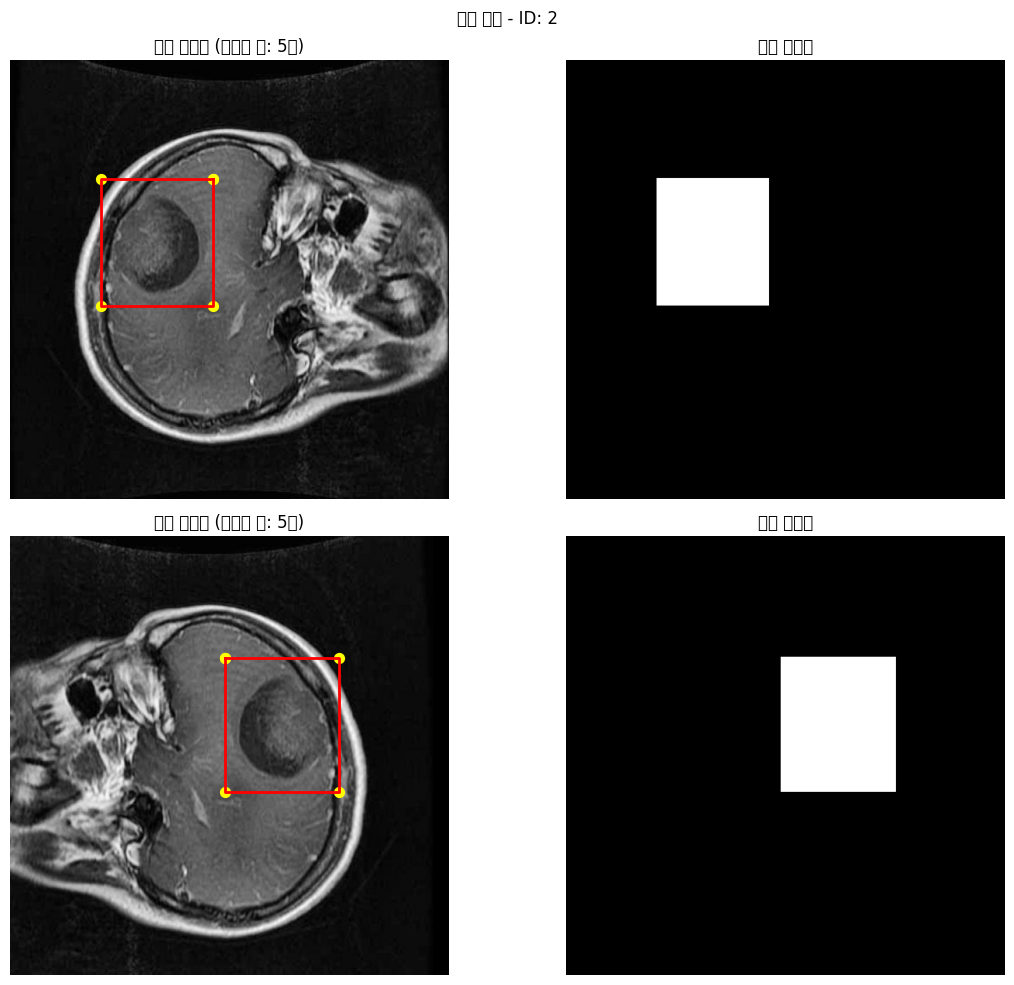

이미지 증강 중:   0%|          | 3/1502 [00:01<09:48,  2.55it/s]

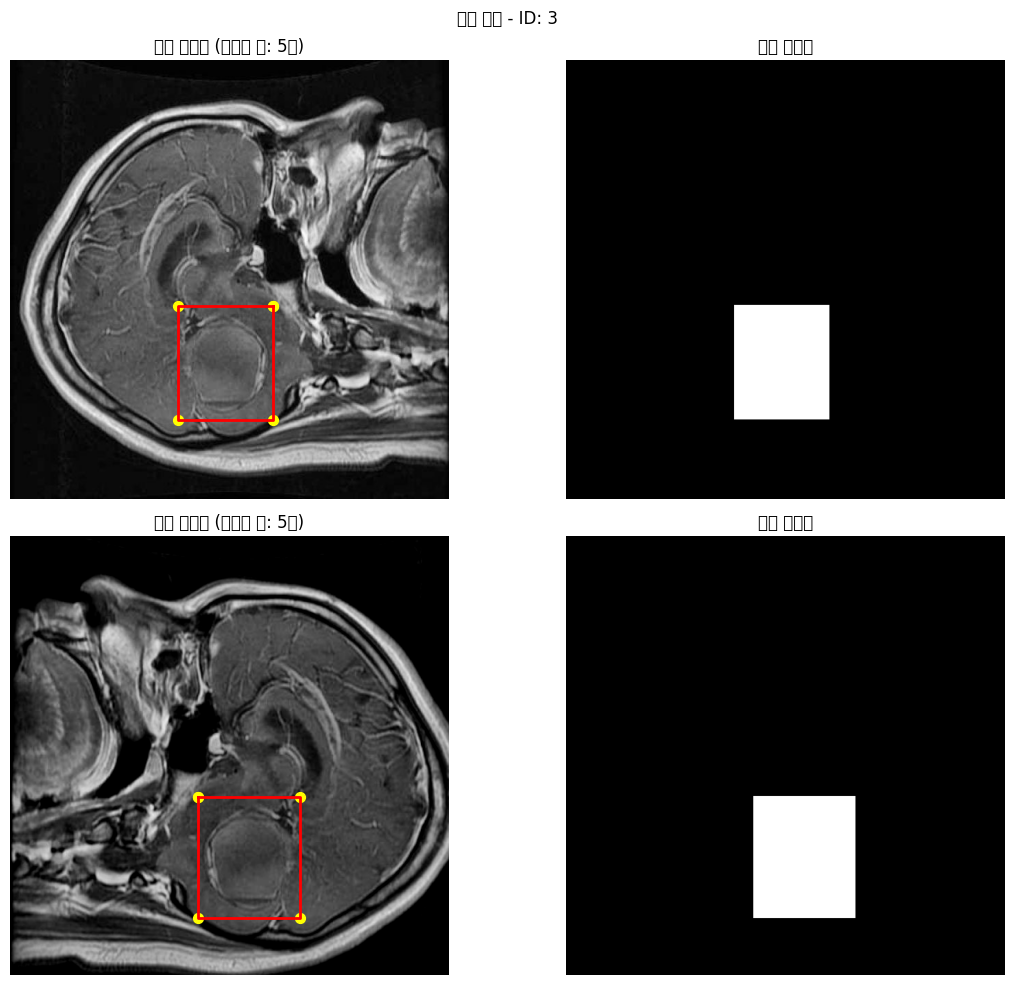

이미지 증강 중:   0%|          | 4/1502 [00:01<09:46,  2.56it/s]

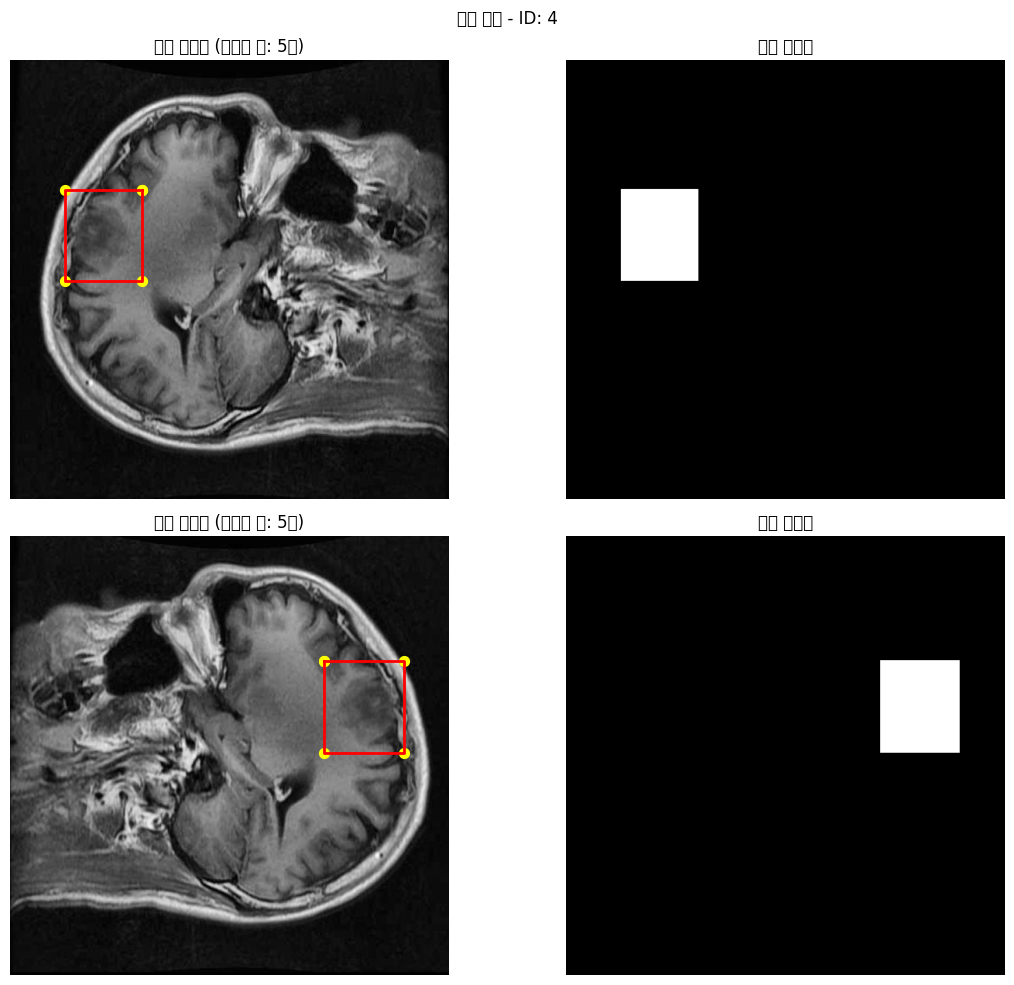

이미지 증강 중: 100%|██████████| 1502/1502 [00:48<00:00, 31.05it/s]


증강된 어노테이션이 저장되었습니다: ./augmented_data\annotations.json

===== 증강 결과 요약 =====
원본 이미지 수: 1502
증강된 이미지 수: 4506
총 이미지 수: 6008
증강 데이터가 저장된 경로: ./augmented_data
증강된 어노테이션 파일: ./augmented_data\annotations.json
증강된 이미지 파일: ./augmented_data\images


In [39]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import albumentations as A
from PIL import Image
import io
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 결과 저장 경로
OUTPUT_PATH = "./augmented_data"
OUTPUT_IMAGES_PATH = os.path.join(OUTPUT_PATH, "images")
OUTPUT_ANNOTATIONS_FILE = os.path.join(OUTPUT_PATH, "annotations.json")

# 출력 디렉토리 생성
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(OUTPUT_IMAGES_PATH, exist_ok=True)

def load_dataset_from_huggingface():
    """
    허깅페이스에서 데이터셋 로드
    """
    print("허깅페이스에서 데이터셋 로드 중...")
    dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")
    print("데이터셋 로드 완료!")
    return dataset

def polygon_to_keypoints(polygon):
    """
    segmentation 다각형 좌표를 키포인트 형식으로 변환
    """
    keypoints = []
    for i in range(0, len(polygon), 2):
        keypoints.append((polygon[i], polygon[i+1]))
    return keypoints

def keypoints_to_polygon(keypoints):
    """
    키포인트 목록을 segmentation 다각형 좌표로 변환
    """
    polygon = []
    for point in keypoints:
        polygon.extend([float(point[0]), float(point[1])])
    return polygon

def calculate_area_from_polygon(polygon, image_shape):
    """
    다각형 좌표로부터 면적 계산
    """
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    # 다각형 좌표 변환
    polygon_points = []
    for i in range(0, len(polygon), 2):
        polygon_points.append([polygon[i], polygon[i+1]])
    
    polygon_array = np.array([polygon_points], dtype=np.int32)
    
    # 다각형 내부를 채우기
    cv2.fillPoly(mask, polygon_array, 1)
    
    # 면적 계산
    return float(np.sum(mask))

def calculate_bbox_from_polygon(polygon):
    """
    다각형 좌표로부터 바운딩 박스 계산
    """
    # x, y 좌표 분리
    x_coords = polygon[0::2]
    y_coords = polygon[1::2]
    
    # 바운딩 박스 좌표 계산
    x_min = float(min(x_coords))
    y_min = float(min(y_coords))
    x_max = float(max(x_coords))
    y_max = float(max(y_coords))
    
    # [x_min, y_min, x_max, y_max] 형식으로 반환
    return [x_min, y_min, x_max, y_max]

def create_mask_from_polygon(polygon, image_shape):
    """
    다각형 좌표로부터 마스크 생성 (시각화용)
    """
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    # 다각형 좌표 변환
    polygon_points = []
    for i in range(0, len(polygon), 2):
        polygon_points.append([polygon[i], polygon[i+1]])
    
    polygon_array = np.array([polygon_points], dtype=np.int32)
    
    # 다각형 내부를 채우기
    cv2.fillPoly(mask, polygon_array, 1)
    
    return mask

def get_augmentation_pipeline():
    """
    의료 이미지에 적합한 증강 파이프라인 정의 (키포인트 변환 지원)
    """
    return A.Compose([
        # 공간적 변환
        A.Rotate(limit=10, p=0.5),  # 작은 각도 회전 (±10°)
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0, p=0.5),  # 이동, 확대/축소
        A.HorizontalFlip(p=0.5),  # 좌우 대칭
        
        # 강도 변환
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # 밝기/대비 조정
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # 노이즈 추가
        A.GaussianBlur(blur_limit=3, p=0.2),  # 블러 추가
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),  # 감마 보정
    ], keypoint_params=A.KeypointParams(format='xy'))  # 키포인트 파라미터 설정

def augment_image_with_polygon(image, polygon, augmentation_pipeline):
    """
    이미지와 다각형 좌표를 함께 증강
    """
    # 다각형 좌표를 키포인트로 변환
    keypoints = polygon_to_keypoints(polygon)
    
    # 이미지와 키포인트 함께 증강
    augmented = augmentation_pipeline(image=image, keypoints=keypoints)
    augmented_image = augmented['image']
    augmented_keypoints = augmented['keypoints']
    
    # 증강된 키포인트를 다시 다각형 좌표로 변환
    augmented_polygon = keypoints_to_polygon(augmented_keypoints)
    
    return augmented_image, augmented_polygon

def visualize_augmentation_result(original_image, original_polygon, augmented_image, augmented_polygon, title="Augmentation Result"):
    """
    원본과 증강 결과 시각화
    """
    # 마스크 생성 (시각화용)
    original_mask = create_mask_from_polygon(original_polygon, original_image.shape)
    augmented_mask = create_mask_from_polygon(augmented_polygon, augmented_image.shape)
    
    # 다각형 꼭지점 추출
    original_points = [(original_polygon[i], original_polygon[i+1]) for i in range(0, len(original_polygon), 2)]
    augmented_points = [(augmented_polygon[i], augmented_polygon[i+1]) for i in range(0, len(augmented_polygon), 2)]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # 원본 이미지와 다각형
    ax1.imshow(original_image)
    ax1.plot([p[0] for p in original_points + [original_points[0]]], 
             [p[1] for p in original_points + [original_points[0]]], 'r-', linewidth=2)
    ax1.scatter([p[0] for p in original_points], [p[1] for p in original_points], color='yellow', s=50)
    ax1.set_title(f'원본 이미지 (꼭지점 수: {len(original_points)}개)')
    ax1.axis('off')
    
    # 원본 마스크
    ax2.imshow(original_mask, cmap='gray')
    ax2.set_title('원본 마스크')
    ax2.axis('off')
    
    # 증강 이미지와 다각형
    ax3.imshow(augmented_image)
    ax3.plot([p[0] for p in augmented_points + [augmented_points[0]]], 
             [p[1] for p in augmented_points + [augmented_points[0]]], 'r-', linewidth=2)
    ax3.scatter([p[0] for p in augmented_points], [p[1] for p in augmented_points], color='yellow', s=50)
    ax3.set_title(f'증강 이미지 (꼭지점 수: {len(augmented_points)}개)')
    ax3.axis('off')
    
    # 증강 마스크
    ax4.imshow(augmented_mask, cmap='gray')
    ax4.set_title('증강 마스크')
    ax4.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def save_image(image, file_path):
    """
    이미지를 파일로 저장
    """
    if isinstance(image, np.ndarray):
        if len(image.shape) == 3 and image.shape[2] == 3:
            # RGB 이미지
            cv2.imwrite(file_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        else:
            # 그레이스케일 이미지
            cv2.imwrite(file_path, image)
    else:
        # PIL 이미지
        image.save(file_path)

def prepare_dataset_for_augmentation(dataset, split='train'):
    """
    허깅페이스 데이터셋에서 증강에 필요한 정보 추출
    """
    data_for_augmentation = []
    
    # 선택한 데이터셋 분할 사용
    ds = dataset[split]
    
    print(f"데이터셋 준비 중: {len(ds)} 이미지")
    
    for i in tqdm(range(len(ds)), desc="데이터 준비 중"):
        item = ds[i]
        
        # 필요한 데이터 필드 추출
        image = np.array(item['image'])
        segmentation = item['segmentation']
        
        # 메타 데이터 추출
        meta = {
            'id': item['id'],
            'category_id': item['category_id'],
            'file_name': f"original_{item['id']}.jpg"
        }
        
        # bbox가 있으면 추가
        if 'bbox' in item:
            meta['bbox'] = item['bbox']
        
        # area가 있으면 추가
        if 'area' in item:
            meta['area'] = item['area']
        
        # 기타 필드 추가
        if 'height' in item:
            meta['height'] = item['height']
        
        if 'width' in item:
            meta['width'] = item['width']
        
        if 'iscrowd' in item:
            meta['iscrowd'] = item['iscrowd']
        
        if 'license' in item:
            meta['license'] = item['license']
        
        # 준비된 데이터 추가
        data_for_augmentation.append({
            'image': image,
            'segmentation': segmentation,
            'meta': meta
        })
        
        # 원본 이미지 저장
        save_image(image, os.path.join(OUTPUT_IMAGES_PATH, meta['file_name']))
    
    return data_for_augmentation

def augment_dataset(data_for_augmentation, num_augmentations=3, visualize=True):
    """
    데이터셋 증강 및 모든 피처 업데이트 (다각형 좌표 직접 변환 방식)
    """
    augmentation_pipeline = get_augmentation_pipeline()
    
    # 결과 어노테이션을 저장할 리스트
    augmented_annotations = []
    
    # 원본 데이터 정보도 저장
    for item in data_for_augmentation:
        augmented_annotations.append(item['meta'])
    
    # 증강 적용
    print(f"\n데이터 증강 시작: {len(data_for_augmentation)} 이미지에 각 {num_augmentations}개 증강 적용")
    
    for idx, item in enumerate(tqdm(data_for_augmentation, desc="이미지 증강 중")):
        try:
            image = item['image']
            segmentation = item['segmentation'][0]  # 첫 번째 다각형 사용
            meta = item['meta']
            
            # 원본 이미지 크기 저장
            original_height, original_width = image.shape[:2]
            
            # 각 이미지마다 여러 증강 적용
            for aug_idx in range(num_augmentations):
                # 이미지와 다각형 좌표 함께 증강
                augmented_image, augmented_polygon = augment_image_with_polygon(
                    image, segmentation, augmentation_pipeline
                )
                
                # 다각형 좌표에서 바운딩 박스 계산
                augmented_bbox = calculate_bbox_from_polygon(augmented_polygon)
                
                # 다각형 좌표에서 면적 계산
                augmented_area = calculate_area_from_polygon(augmented_polygon, augmented_image.shape)
                
                # 증강된 이미지의 크기
                augmented_height, augmented_width = augmented_image.shape[:2]
                
                # 새 파일명 생성
                augmented_filename = f"aug_{meta['id']}_{aug_idx}.jpg"
                
                # 증강된 이미지 저장
                save_image(augmented_image, os.path.join(OUTPUT_IMAGES_PATH, augmented_filename))
                
                # 모든 필드를 포함하는 증강된 어노테이션 생성
                augmented_meta = meta.copy()
                
                # 필수 필드 업데이트
                augmented_meta['file_name'] = augmented_filename
                augmented_meta['id'] = f"{meta['id']}_aug_{aug_idx}"
                augmented_meta['segmentation'] = [augmented_polygon]
                
                if 'bbox' in meta or len(augmented_bbox) > 0:
                    augmented_meta['bbox'] = augmented_bbox
                
                if 'area' in meta or augmented_area > 0:
                    augmented_meta['area'] = augmented_area
                
                if 'height' in meta:
                    augmented_meta['height'] = augmented_height
                
                if 'width' in meta:
                    augmented_meta['width'] = augmented_width
                
                # date_captured 필드가 있으면 현재 시간으로 업데이트
                if 'date_captured' in meta:
                    augmented_meta['date_captured'] = datetime.now().strftime("%Y-%m-%dT%H:%M:%S+00:00")
                
                # 증강된 어노테이션 추가
                augmented_annotations.append(augmented_meta)
                
                # 시각화 (첫 5개 이미지의 첫 번째 증강만)
                if visualize and idx < 5 and aug_idx == 0:
                    visualize_augmentation_result(
                        image, segmentation,
                        augmented_image, augmented_polygon,
                        title=f"증강 결과 - ID: {meta['id']}"
                    )
        
        except Exception as e:
            print(f"오류 발생: ID {meta['id']} - {str(e)}")
            continue
    
    return augmented_annotations

def save_annotations(annotations, output_file):
    """
    증강된 어노테이션 저장
    """
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(annotations, f, indent=2, ensure_ascii=False)
    print(f"증강된 어노테이션이 저장되었습니다: {output_file}")

def main():
    # 1. 허깅페이스에서 데이터셋 로드
    dataset = load_dataset_from_huggingface()
    
    # 2. 데이터셋 정보 확인
    print("\n데이터셋 구조:")
    print(dataset)
    
    train_ds = dataset['train']
    print(f"\n훈련 데이터셋 크기: {len(train_ds)} 이미지")
    
    # 3. 데이터셋 특성 확인
    print("\n데이터셋 특성:")
    print(train_ds.features)
    
    # 4. 첫 번째 샘플 확인
    print("\n첫 번째 샘플 예시:")
    example = train_ds[0]
    for key, value in example.items():
        if key != 'image':
            print(f"{key}: {value}")
        else:
            print(f"{key}: {type(value)} (shape: {np.array(value).shape})")
    
    # 5. 데이터셋 준비
    data_for_augmentation = prepare_dataset_for_augmentation(dataset, split='train')
    
    # 6. 데이터셋 증강
    augmented_annotations = augment_dataset(
        data_for_augmentation, 
        num_augmentations=3,
        visualize=True
    )
    
    # 7. 어노테이션 저장
    save_annotations(augmented_annotations, OUTPUT_ANNOTATIONS_FILE)
    
    # 8. 결과 요약
    original_count = len(data_for_augmentation)
    augmented_count = len(augmented_annotations) - original_count
    total_count = len(augmented_annotations)
    
    print("\n===== 증강 결과 요약 =====")
    print(f"원본 이미지 수: {original_count}")
    print(f"증강된 이미지 수: {augmented_count}")
    print(f"총 이미지 수: {total_count}")
    print(f"증강 데이터가 저장된 경로: {OUTPUT_PATH}")
    print(f"증강된 어노테이션 파일: {OUTPUT_ANNOTATIONS_FILE}")
    print(f"증강된 이미지 파일: {OUTPUT_IMAGES_PATH}")

if __name__ == "__main__":
    main()

# HuggingFace Upload

In [ ]:
!pip install datasets huggingface_hub pillow

In [ ]:
from datasets import Dataset, Features, Value, Sequence, Image
from huggingface_hub import login
import os
import json
from PIL import Image as PILImage

# 토큰으로 로그인
login(token="")

# 증강된 데이터셋 경로
AUGMENTED_PATH = "./augmented_data"
AUGMENTED_IMAGES_PATH = os.path.join(AUGMENTED_PATH, "images")
AUGMENTED_ANNOTATIONS_FILE = os.path.join(AUGMENTED_PATH, "annotations.json")

# 어노테이션 로드
with open(AUGMENTED_ANNOTATIONS_FILE, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

# 데이터 타입 및 구조 확인
print("데이터 구조 확인 중...")
keys_set = set()
for annotation in annotations[:10]:
    for key in annotation.keys():
        keys_set.add(key)
print(f"데이터에 있는 모든 키: {keys_set}")

# 데이터 타입 명시
features = Features({
    "id": Value("string"),
    "file_name": Value("string"),
    "image": Image(),  # 이미지 타입 추가
    "category_id": Value("int64"),
})

# segmentation 필드 추가
if "segmentation" in keys_set:
    features["segmentation"] = Sequence(Sequence(Value("float32")))

# bbox 필드 추가
if "bbox" in keys_set:
    features["bbox"] = Sequence(Value("float32"))

# area 필드 추가
if "area" in keys_set:
    features["area"] = Value("float32")

# 기타 필드 추가
for key in keys_set:
    if key not in features:
        features[key] = Value("string")

print(f"사용할 피처 스키마: {features}")

# 데이터 준비 함수 - 이미지 포함
def prepare_dataset_from_annotations(annotations):
    data = {
        "id": [],
        "file_name": [],
        "image": [],
    }
    
    # 기존에 있는 키들을 모두 포함
    for key in keys_set:
        if key not in ["id", "file_name", "image"]:
            data[key] = []
    
    for idx, annotation in enumerate(annotations):
        try:
            # id 처리
            data["id"].append(str(annotation.get("id", f"unknown_{idx}")))
            
            # file_name 처리
            file_name = annotation.get("file_name", "")
            data["file_name"].append(file_name)
            
            # 이미지 로드
            image_path = os.path.join(AUGMENTED_IMAGES_PATH, file_name)
            if os.path.exists(image_path):
                img = PILImage.open(image_path)
                data["image"].append(img)
            else:
                print(f"경고: 이미지 파일을 찾을 수 없습니다: {image_path}")
                # 빈 이미지 생성 (오류 방지)
                data["image"].append(PILImage.new('RGB', (640, 640), color='black'))
            
            # category_id 처리
            if "category_id" in keys_set:
                data["category_id"].append(int(annotation.get("category_id", 0)))
            
            # segmentation 처리
            if "segmentation" in keys_set:
                if "segmentation" in annotation and annotation["segmentation"]:
                    data["segmentation"].append(annotation["segmentation"])
                else:
                    data["segmentation"].append([[]])
            
            # bbox 처리
            if "bbox" in keys_set:
                if "bbox" in annotation and annotation["bbox"]:
                    data["bbox"].append(annotation["bbox"])
                else:
                    data["bbox"].append([])
            
            # area 처리
            if "area" in keys_set:
                if "area" in annotation and annotation["area"] is not None:
                    data["area"].append(float(annotation["area"]))
                else:
                    data["area"].append(0.0)
            
            # 나머지 필드들 처리
            for key in keys_set:
                if key not in ["id", "file_name", "image", "category_id", "segmentation", "bbox", "area"]:
                    if key in annotation:
                        data[key].append(str(annotation[key]))
                    else:
                        data[key].append("")
                        
            # 진행 상황 표시
            if idx % 100 == 0:
                print(f"처리 중: {idx}/{len(annotations)}")
                
        except Exception as e:
            print(f"오류 발생 (항목 {idx}): {str(e)}")
    
    return data

# 데이터 준비
print("데이터셋 준비 중...")
dataset_data = prepare_dataset_from_annotations(annotations)

# 명시적 스키마로 데이터셋 생성
dataset = Dataset.from_dict(dataset_data, features=features)

# 데이터셋 업로드
print("데이터셋 업로드 중...")
dataset.push_to_hub(
    "espada105/augmented-brain-tumor-segmentation",
    private=False
)

print("데이터셋 업로드 완료!")

데이터 구조 확인 중...
데이터에 있는 모든 키: {'category_id', 'iscrowd', 'id', 'area', 'width', 'license', 'bbox', 'file_name', 'height'}
사용할 피처 스키마: {'id': Value(dtype='string', id=None), 'file_name': Value(dtype='string', id=None), 'image': Image(mode=None, decode=True, id=None), 'category_id': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'area': Value(dtype='float32', id=None), 'iscrowd': Value(dtype='string', id=None), 'width': Value(dtype='string', id=None), 'license': Value(dtype='string', id=None), 'height': Value(dtype='string', id=None)}
데이터셋 준비 중...
처리 중: 0/6008
처리 중: 100/6008
처리 중: 200/6008
처리 중: 300/6008
처리 중: 400/6008
처리 중: 500/6008
처리 중: 600/6008
처리 중: 700/6008
처리 중: 800/6008
처리 중: 900/6008
처리 중: 1000/6008
처리 중: 1100/6008
처리 중: 1200/6008
처리 중: 1300/6008
처리 중: 1400/6008
처리 중: 1500/6008
처리 중: 1600/6008
처리 중: 1700/6008
처리 중: 1800/6008
처리 중: 1900/6008
처리 중: 2000/6008
처리 중: 2100/6008
처리 중: 2200/6008
처리 중: 2300/6008
처리 중: 2400/600

Uploading the dataset shards: 100%|██████████| 1/1 [01:46<00:00, 107.00s/it]
c:\Users\tjddl\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tjddl\.cache\huggingface\hub\datasets--espada105--augmented-brain-tumor-segmentation. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn

데이터셋 업로드 완료!
